In [1]:
import numpy as np
from numpy import sin, cos, sqrt, arctan, deg2rad, rad2deg
import matplotlib.pyplot as plt

In [2]:
def compute_transition(accel, gamma):
    # constants
    g = 9.8              # acceleration of gravity, m/s^2
    
    # rough dimensions of cessna 172
    m = 1000  # mass, kg
    s = 16  # wing area, m^2
    
    # aerodynamics
    CL_max = 1.2  # max CL
    CD = 0.01 + 0.1*CL_max**2 # CD estimate
    rho = 1.225  # density of air
    alpha = deg2rad(15)  # angle of attack at CL_max, rad

    # compute v stall
    W = m*g
    theta = alpha + gamma
    V_stall = sqrt(2*W/(rho*s*CL_max))
    
    # compute transition time
    t_transition = V_stall/accel  # time to transition
    t = np.linspace(0, 2*t_transition, 1000)

    # accelerations, assumes we maintain flight path angle, so accel in direction of velocity
    a = np.where(t < t_transition, accel, 0)
    xdd = a*cos(gamma)
    zdd = a*sin(gamma)
    
    # compute aero forces
    V = np.where(t < t_transition, accel*t, V_stall)
    q = 0.5*rho*V**2
    L = CL_max*q*s
    D = CD*q*s

    # compute thrust
    delta = arctan((m*zdd - L*cos(gamma) + W + D*sin(gamma))/(m*xdd + D*cos(gamma) + L*sin(gamma)))
    T = np.where(
        abs(theta + delta) < 0.1, 
        (m*xdd + L*sin(gamma) + D*cos(gamma))/(cos(theta + delta)),
        (m*zdd - L*cos(gamma) + W + D*sin(gamma))/(sin(theta + delta)))

    # estimate fuel consumption and power
    fuel_energy_density = 42.8e6 # J/kg, aviation jet fuel
    efficiency = 1
    tsfc = 48*1e-6 # kg/(N-s) https://en.wikipedia.org/wiki/Thrust-specific_fuel_consumption
    adjust = 0.02558346743913131 # set so P=D*V for steady level flight, should try to justify
    m_dot = tsfc*T*adjust
    P = m_dot*fuel_energy_density/efficiency
    return locals()

In [3]:
def plot_transition(res, label):
    p1 = plt.figure(1)
    plt.plot(res['t'], rad2deg(res['delta']), label=label)
    plt.xlabel('t, s')
    plt.ylabel('Thrust Angle, deg')
    plt.legend()

    p2 = plt.figure(2)
    plt.plot(res['t'], res['a']/9.8, label=label)
    plt.xlabel('t')
    plt.ylabel("Acceleration, g's")
    plt.legend()

    p3 = plt.figure(3)
    plt.plot(res['t'], res['T'], label=label)
    plt.xlabel('t, s')
    plt.ylabel('Thrust, N')
    plt.legend()

    p4 = plt.figure(4)
    plt.plot(res['t'], res['D'], label=label)
    plt.xlabel('t, s')
    plt.ylabel('Drag, N')
    plt.legend()

    p5 = plt.figure(5)
    plt.plot(res['t'], res['V'], label=label)
    plt.xlabel('t, s')
    plt.ylabel('Velocity, m/s')
    plt.legend()

    p6 = plt.figure(6)
    hp_to_joules = 745.70
    plt.plot(res['t'], res['P']/hp_to_joules, label=label)
    plt.xlabel('t, s')
    plt.ylabel('Power, hp')
    plt.legend()

    p7 = plt.figure(7)
    plt.plot(res['t'], res['T']/res['W'], label=label)
    plt.xlabel('t, s')
    plt.ylabel('Thrust/Weight')
    plt.legend()
    
    return [p1, p2, p3, p4, p5, p6, p7]

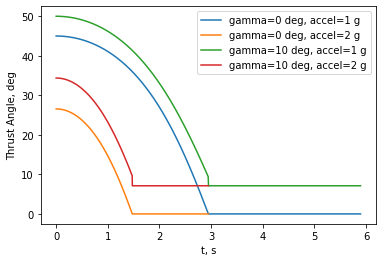

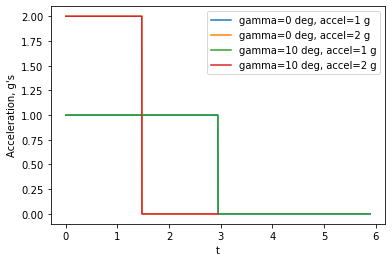

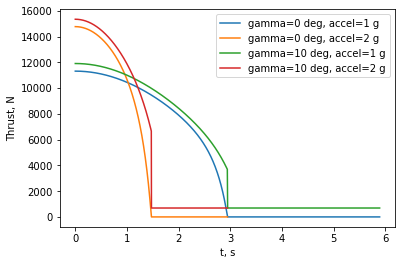

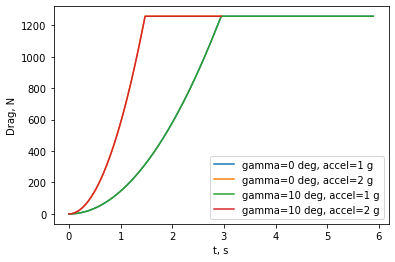

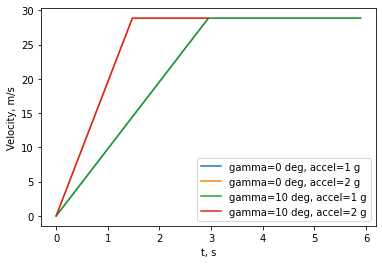

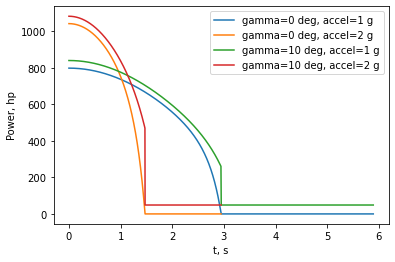

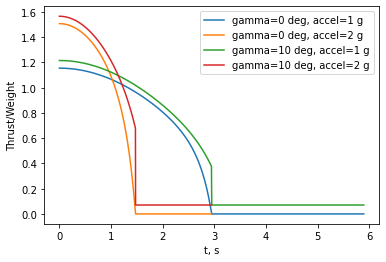

In [4]:
for gamma_deg in [0, 10]:
    for accel_g in [1, 2]:
        res = compute_transition(accel=accel_g*9.8, gamma=deg2rad(gamma_deg))
        plot_transition(res, 'gamma={:g} deg, accel={:g} g'.format(gamma_deg, accel_g))
plt.legend()